# Task 1: Form group

"Project Group 0" consists of Tobias Sædder Schiolborg, Johannes Brøns Christensen and Silas Nøstvik.

# Task 2: Forming database

Explaining choice of schema design:

Below the schema design can be seen in the shape of two different kinds of E/R diagrams.
Among the design choices were:

 - "Author", "Tag", and "Meta_keywords" are entity sets:
     An article can have a large number authors, tags, and (meta_)keywords.
     Therefore they are not atomic and may not be attributes of the article.

 - "Domain" is a entity set:
     If any domain value needs to be changed, the changes need not be applied on all records in the
     articles relation, but only on the domain relation.

 - There is a functional dependency: "Domain" -> "Type". Therefore "type" is an attribute of "Domain". 
 
 - Since "NULL" usually represents an unknown value in a relation, the type value "unknown" will be changed to "NULL"

 - Omit "keywords", "source", and "summary" column:
     As these columns did not contain any non-NULL values for all 1 million rows in the csv-file, 
     they were omitted. The "Meta_keywords" column did, on the other hand, contain information.

 - Letting times at scrape, insert, and update be attributes - not an entity set with according relationship sets:
     timestamps are atomic and not really disambiguous in any way, so they serve well as attributes.



In [3]:
#import modules
import psycopg2 #To connect and use PostgreSQL on the FakeNewsCorpus-database.
from time import process_time #To understand system/CPU time in python e.g. timestamps. 
from IPython.display import Image #To display handdrawn pictures to you from our system. 
import matplotlib.pyplot as plt #To create graphical illustrations of our data-exploration. 
import numpy as np #To be able to effectively perform operation of multidimensional arrays. 
import pandas as pd #To clean/manipulate and analyze the data in csv file format. 

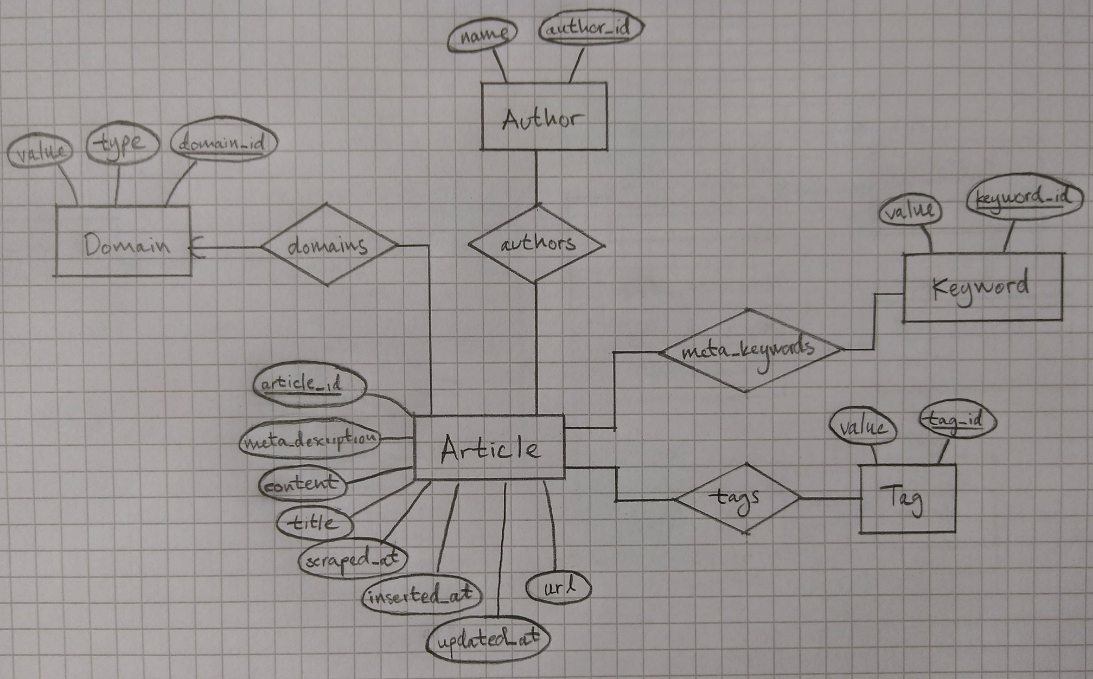

In [2]:
Image("pics/er_diagram.png",width=800) #Do not run this. If you do: redownloead our notebook in order to see picture.

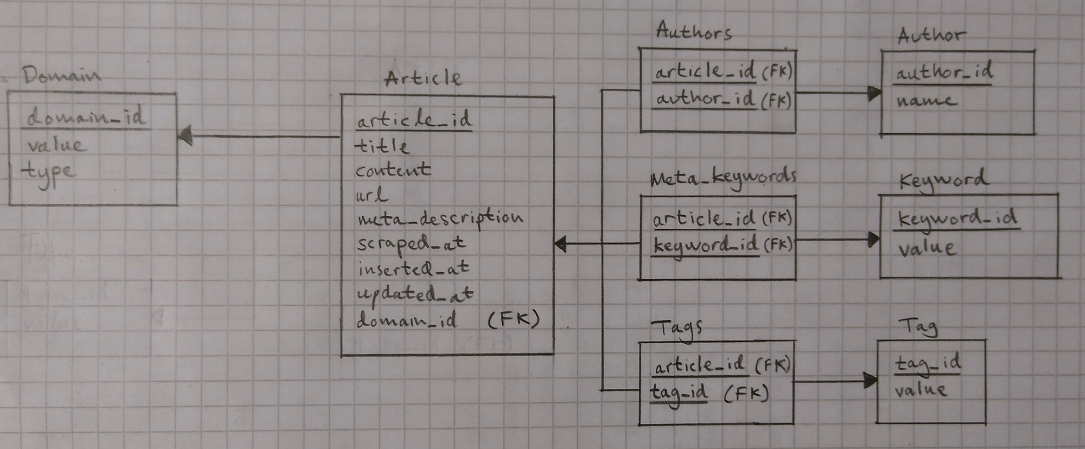

In [3]:
Image("pics/er_relation.png",width=800) #Do not run this. If you do: redownloead our notebook in order to see picture.

Demonstrating a working database:

In [5]:
#Function for queries with database
def execQuery(query,*printOption):
    try:
        connection = psycopg2.connect(user = "tobias",
                                      password = "1234",
                                      host = "localhost",
                                      port = "5432",
                                      database = "fake_news")
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL:", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            if not printOption:
                print("Executed query and closed connection.")

#number of articles in database
query0 = """
SELECT COUNT(*) 
FROM article
"""

execQuery(query0)[0][0]

Executed query and closed connection.


999934

It is seen that the total number of articles in the database is 999934 and that the database support simple queries.

# Task 3: Queries

### Query3_1: List the domains of news articles of reliable type and scrapped at or after January 15, 2018. NOTE: Do not include duplicate domains in your answer.

In [5]:
#SQL:
query3_1 = """
SELECT DISTINCT d.value
FROM article a INNER JOIN
    domain d USING (domain_id)
WHERE d.type = 'reliable' AND
    a.scraped_at::date >= '2018-01-25'
"""

[r[0] for r in execQuery(query3_1)]

Executed query and closed connection.


['christianpost.com', 'consortiumnews.com', 'nutritionfacts.org']

From query3_1 it can be concluded that the domains listed above meets the criteria of the task. 


Relational algebra:

a := article

d := domain

π_(d.value)( a ⨝_(a.domain_id=d.domain_id ∧ a.scraped_at>=2018-01-25 ∧ d.type='reliable') d )

### Query3_2: List the name(s) of the most prolific author(s) of news articles of fake type. An author is among the most prolific if it has authored as many or more fake news articles as any other author in the dataset.

In [6]:
#SQL:
query3_2 = """
WITH s(name,n) AS (
    SELECT author.name, count(*)
    FROM authors
    INNER JOIN author USING(author_id)
    INNER JOIN article USING(article_id)
    INNER JOIN domain USING(domain_id)
    WHERE domain.type = 'fake'
    GROUP BY name)
SELECT name,n
FROM s
WHERE n >= (SELECT MAX(n) FROM s)
"""

execQuery(query3_2)[0]

Executed query and closed connection.


('John Rolls', 1146)

From query3_2 it can be concluded that 'John Rolls' is the most prolific Fake Author of the dataset.

Extended relational algebra:

a := article

t := type

au := author

aus := authors

a_count := γ_(au.name,COUNT(a.article_id)->cnt)( au ⨝_(au.author_id=aus.author_id ∧ au.name!=NULL) aus 
               ⨝_(aus.article_id=a.article_id) a ⨝_(a.domain_id=d.domain_id ∧ d.type='fake') d )

π_(name, cnt)( σ_(cnt = π_(MAX(cnt))(a_count)) ( a_count ) )


### Query3_3: Count the pairs of article IDs that exhibit the exact same set of meta-keywords, but only return the pairs where the set of meta-keywords is not empty.

As this is a computationally expensive operation, we are allowed to check down to 500 articles for pairs. 
We choose to check the first 10000 articles.

In [7]:
#SQL:
query3_3 = """
WITH s(article_id,keyword_lst) AS (
SELECT article_id, array_agg(value)
FROM meta_keywords 
    INNER JOIN keyword USING (keyword_id)
    INNER JOIN (SELECT article_id 
                FROM article
                ORDER BY article_id ASC LIMIT 10000
                ) AS small_article 
    USING (article_id)
GROUP BY article_id
)

SELECT COUNT(*)
FROM s s1, s s2
WHERE s1.keyword_lst @> s2.keyword_lst
    AND s2.keyword_lst @> s1.keyword_lst
    AND s1.article_id < s2.article_id
"""
execQuery(query3_3)[0][0]

Executed query and closed connection.


77117

From query3_3 it can be concluded that the first 10000 articles of the dataset has in total 77117 pairs of articles with the exact same set of meta-keywords.

# Task 4: Invent own queries

### Query 4_1: Given an article by an author who have written for multiple domains, what is the probability that the article will belong to a certain domain type ('reliable', 'fake' etc)?

Let's define some events regarding some article in the dataset (in the probability theoric sense):

A: the article belongs to a specific domain type

B: the article was written by an author who has written articles for multiple domains.

What we are looking for is the conditional probability P(A|B), i.e. the probability that - given the article was written by an author who has written for multiple domains - this article belongs to some specific domain type. A conditional probability is defined as:

P(A|B) = P(A∩B)/P(B)

Looking at the righthand-side probabilites respectively (all articles weighing equally):

P(A∩B) = (number of articles where both A and B occured) / (total number of articles)

P(B) = (number of articles where B occured) / (total number of articles)

The conditional probability is then:

P(A|B) = (number of articles where both A and B occured) / (number of articles where B occured)

The denominator and numerator above can be found using the following query: 

In [8]:
#Numerator: listing, by domain type grouping, the number of articles written by authors 
#who have written for multiple domains
query4_1 = """
WITH author_mult AS(
SELECT author_id
FROM authors aus INNER JOIN
    article a USING (article_id) INNER JOIN
    domain d USING (domain_id)
GROUP BY (author_id)
HAVING (COUNT(DISTINCT domain_id)>1)
)

SELECT d.type, COUNT (distinct article_id) as cnt
FROM domain d INNER JOIN
    article a USING (domain_id) INNER JOIN
    authors aus USING (article_id) INNER JOIN
    author_mult au_m USING (author_id)
GROUP BY (d.type)
"""

res4_1 = execQuery(query4_1)
#gives the output
res4_1

Executed query and closed connection.


[('bias', 35352),
 ('clickbait', 4185),
 ('conspiracy', 14671),
 ('fake', 7663),
 ('hate', 959),
 ('junksci', 7090),
 ('political', 77306),
 ('reliable', 440),
 ('rumor', 1323),
 ('satire', 106),
 ('unreliable', 2065),
 (None, 21609)]

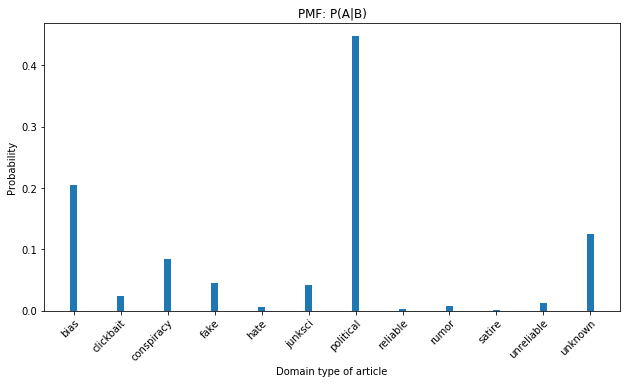

In [9]:
#Plotting the probability mass function for P(A|B)
if res4_1:
    total = sum(list(list(zip(*res4_1))[1])) #denominator
    
    types = list(map(lambda x: x[0] if x[0] else "unknown",res4_1))
    values = list(map(lambda x: x[1]/total,res4_1))
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(types,values,width=0.15)
    ax.set_xlabel('Domain type of article')
    ax.set_ylabel('Probability')
    ax.set_title('PMF: P(A|B)')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

Above the PMF for the probability P(A|B) can be seen.
We want to compare this PMF with the  PMF for P(A), i.e. the probability that an article will be of a certain type. Below we compute P(A):

Executed query and closed connection.


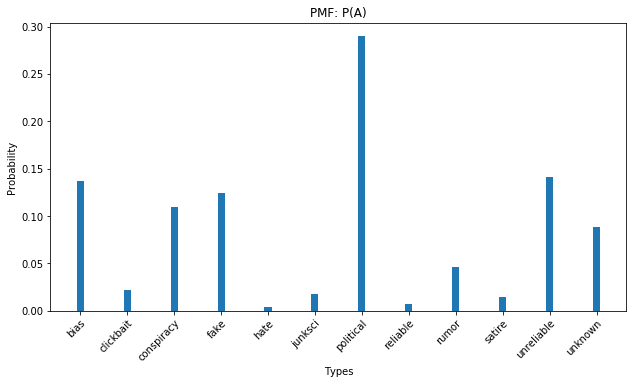

In [10]:
# Probability an article is of a certain type (all articles)
query9 = """
SELECT type, count(*)
FROM article
    INNER JOIN domain USING (domain_id)
GROUP BY type
"""
res9 = execQuery(query9)

if res9:
    sum9 = sum(list(list(zip(*res9))[1]))
    x = list(list(zip(*res9))[0])
    y = list(list(zip(*res9))[1])
    x = list(map(lambda z: z if z else 'unknown',x))
    y = list(map(lambda z: z/sum9,y))
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel('Types')
    ax.set_ylabel('Probability')
    ax.set_title('PMF: P(A)')
    plt.bar(x,y,width=0.15)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

By comparing the two charts, it is seen that articles by authors, who have written for MORE than one domain, are less likely to be of types: conspiracy, fake and unreliable.

### Query 4_2: Looking at all authors who have written for multiple domains of different types, what are the most common combinations of these types?

In [6]:
#Query 4_2
query4_2 = """
SELECT array_agg(distinct d.type)
FROM authors aus
    INNER JOIN article a USING (article_id)
    INNER JOIN domain d USING (domain_id)
GROUP BY aus.author_id
HAVING COUNT(DISTINCT d.type)>1;
"""

res4_2 = execQuery(query4_2)
#gives the output
res4_2

Executed query and closed connection.


[(['conspiracy', 'political'],),
 (['bias', 'junksci'],),
 (['bias', 'conspiracy', None],),
 (['political', 'unreliable'],),
 (['bias', 'rumor'],),
 (['junksci', 'political'],),
 (['bias', 'conspiracy'],),
 (['bias', 'political'],),
 (['bias', 'political', None],),
 (['bias', 'political'],),
 (['political', 'reliable'],),
 (['conspiracy', 'political'],),
 (['bias', 'rumor'],),
 (['conspiracy', 'political'],),
 (['junksci', 'rumor'],),
 (['conspiracy', 'junksci', None],),
 (['clickbait', 'political'],),
 (['conspiracy', 'fake', 'junksci'],),
 (['bias', 'political'],),
 (['clickbait', 'conspiracy'],),
 (['bias', 'political'],),
 (['political', 'rumor'],),
 (['bias', 'reliable'],),
 (['clickbait', 'conspiracy'],),
 (['bias', 'clickbait', 'conspiracy', 'satire'],),
 (['political', 'rumor'],),
 (['bias', 'reliable', None],),
 (['rumor', 'satire'],),
 (['fake', 'political'],),
 (['conspiracy', 'junksci'],),
 (['bias', 'political'],),
 (['junksci', 'rumor'],),
 (['clickbait', 'unreliable'],),

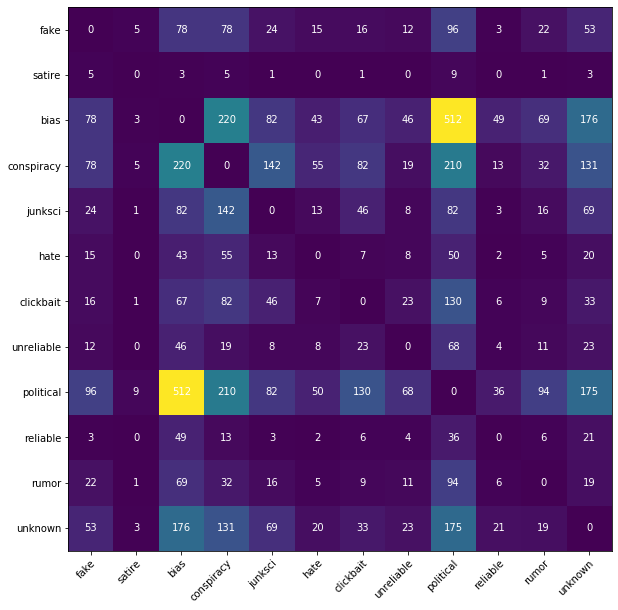

In [7]:
#creating visualization
if res4_2:
    #initializing
    types = ['fake','satire','bias','conspiracy','junksci','hate','clickbait','unreliable',
             'political','reliable','rumor',None]
    d = {(a,b):0 for a in types for b in types}
    #counting pairs of types
    for tup in res4_2:
        lst = tup[0]
        for i in range(len(lst)):
            for j in range(len(lst)):
                if lst[i] != lst[j]:
                    d[lst[i],lst[j]] = d[lst[i],lst[j]] + 1
                    
    #creating 11x11 numpy array of counted pairs                
    num = np.array([[d[a,b] for b in types] for a in types])
    
    #creating heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(num)

    ax.set_xticks(np.arange(len(types)))
    ax.set_yticks(np.arange(len(types)))
    ax.set_ylim(len(types)-0.5, -0.5) #Manual 'bug-workaround' for matplot: Some systems cut off a bit of the heatmap. See: https://github.com/matplotlib/matplotlib/issues/14751
    
    ax.set_xticklabels(types[:-1]+['unknown'])
    ax.set_yticklabels(types[:-1]+['unknown'])

    # Rotate the tick labels of x-axis and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(types)):
        for j in range(len(types)):
            text = ax.text(j, i, num[i, j], ha="center", va="center", color="w")
    
    plt.show()

The heatmap indicates that 'political/bias' is the most common combination of different domain types for an author to write for.  
Other common combinations: 'conspiracy/bias', 'political/conspiracy', and 'unknown/bias'.

### Query 4_3: Looking at the domanin extensions ('com','org' etc.) present in  the domains of the dataset, which domain types do these domain extensions appear in?

In [8]:
# The list of the different possible types in the FakeNewsCorpus data set, that is not NULL/None.
types = ['rumor','hate','unreliable','conspiracy','clickbait','satire','fake','reliable','bias','political','junksci',None]

# The most common domain exstensions found in the FakeNewsCorpus data set.
domExtLst = ["com", "org"]
domExtLst2 = domExtLst + ["other"]


In [9]:
#defing pieces of queries
piece1 = """SELECT type, count(*)
            FROM domain
            WHERE value LIKE '%."""
piece2 = """ GROUP BY type"""
piece3 = """SELECT type, count(*)
       FROM domain
       WHERE NOT ("""
piece4 = """value like '%."""
piece5 = """SELECT count(*) FROM domain WHERE value LIKE '%."""
piece6 = """SELECT count(*) FROM domain WHERE NOT("""

#initializing dictionary for value storage
d = {(a,b):0 for a in types for b in domExtLst2}
nr_domains_with_ext = {}

#iterating over domain extensions
for idx,domExt in enumerate(domExtLst):
    #assembling and executing query for every domain extension
    res4_3a = execQuery(piece1+domExt+"'"+piece2,"No print") #type, count
    res4_3b = execQuery(piece5+domExt+"'","No print") #count
    
    dv = 1
    #extracting count value from query output
    if res4_3b: dv = res4_3b[0][0]
    nr_domains_with_ext[domExt] = dv
    
    #calculating and storing percentage of type for the given domain extension
    if res4_3a:
        for a,b in res4_3a:
            d[a,domExt] = b/dv
    if idx == 0:
        piece3 += piece4+domExt+"'"
        piece6 += piece4+domExt+"'"
    else:
        piece3 += " OR "+piece4+domExt+"'"
        piece6 += " OR "+piece4+domExt+"'"
        
#listing, by type grouping, the number of domain extensions not in domExtLst
query4_3c = piece3 + """) GROUP BY type"""
#count the domain extensions in query4_3c
query4_3d = piece6 + ")"

#executing queries
res4_3c = execQuery(query4_3c,"No print")
res4_3d = execQuery(query4_3d,"No print")

#which gives the outputs:
print('query4_3c:')
print(res4_3c)
print('query4_3d:')
print(res4_3d)

query4_3c:
[('satire', 7), ('hate', 1), (None, 6), ('bias', 4), ('conspiracy', 7), ('junksci', 1), ('fake', 3), ('unreliable', 4), ('rumor', 1)]
query4_3d:
[(34,)]


In [10]:
dv = 1
#extracting count value from query output
if res4_3d: dv = res4_3d[0][0]
nr_domains_with_ext['other'] = dv

#adding domain extensions of category 'other' to dictionary
if res4_3c:
    for a,b in res4_3c:
        d[a,'other'] = b/dv
#converting to numpy array
num = np.array([[d[a,b] for a in types] for b in domExtLst2])
num = np.around(num, decimals=3)

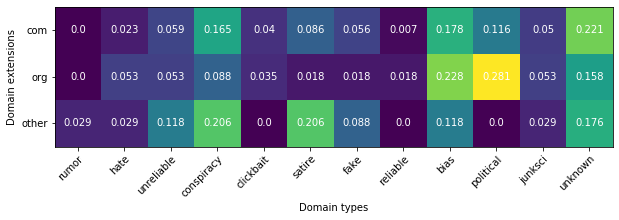

In [11]:
#creating heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(num)

ax.set_xticks(np.arange(len(types)))
ax.set_yticks(np.arange(len(domExtLst2)))

ax.set_xticklabels(types[:-1]+['unknown'])
ax.set_yticklabels(domExtLst2)
ax.set_ylim(len(domExtLst2)-0.5, -0.5)

ax.set_xlabel('Domain types')
ax.set_ylabel('Domain extensions')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(domExtLst2)):
    for j in range(len(types)):
        text = ax.text(j, i, num[i, j],
                       ha="center", va="center", color="w")

plt.show()

The heatmap shows the probability of a domain for a certain type given it has a specific domain extension.
The most frequent domain extension are by far 'com' while the rest are less frequent. This is shown here:

In [17]:
nr_domains_with_ext

{'com': 303, 'org': 57, 'other': 34}

The domains with extension 'com' or 'org' are more likely to be of types bias, political or unknown, and for 'com' it can also be of type conspiracy.
The not so common domain extensions are more likely to be of types unreliable, conspiracy, satire, bias and unknown, and not political unlike the 'com' and 'org'.
As shown bellow, it should also be noted that the most common types of domains are unknown, bias, conspiracy and political, therefore they stand out more in the heatmap.

In [18]:
#number of domains grouped by domain types
query4_3e = """select type, count(*)
           from domain
           group by type"""
execQuery(query4_3e,"No print")

[('clickbait', 14),
 ('unreliable', 25),
 ('rumor', 1),
 ('reliable', 3),
 ('political', 51),
 ('satire', 34),
 ('hate', 11),
 (None, 82),
 ('bias', 71),
 ('junksci', 19),
 ('conspiracy', 62),
 ('fake', 21)]

This investigation of the domain extensions being of the different domain types (among other things) illustrates non-uniformly distributed Domain extensions, domain types and the importance knowing the domain-extensions when guessing which domain type it is. 

# Task 5: Scraping

The scraping of wikinews.org was done using "scrapy", a popular webcrawling framework. Having group number 0 meant having to scrape all articles within the starting letter range:

In [20]:
'ABCDEFGHIJKLMNOPRSTUVWZABCDEFGHIJKLMNOPRSTUVWZ'[0%23:0%23+10]

'ABCDEFGHIJ'

#### Work process
The first step is deciding on a starting url for the spider to crawl from. The <a href="https://en.wikinews.org/wiki/Category:Politics_and_conflicts">given url</a> is nonoptimal, so the crawling instead starts from <a href='https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&from=A'>another url</a> which contains the desired articles starting from "A" and furthermore has a "next page" link navigating to more articles, making it an ideal start url.

A spider class, "[newsSpider](#newsSpider)", is then programmed to systematically crawl to each desired article page of the starting page, scraping their contents, and writing to the csv-file "article.csv". Having done so, the spider navigates to the next page and scrapes more articles. The process stops when all articles titles starting with letter "j" are scraped.

#### Results

The resulting csv-file is loaded into a pandas dataframe:

In [15]:
df = pd.read_csv('scrapy_wikinews/scrape_wikinews.csv')
df

,id,title,url,date_written,keywords,content
0,0,A 1-year long strike against FMC Novamed: Wome...,https://en.wikinews.org/wiki/A_1-year_long_str...,2007-09-17,"['September 17, 2007', 'Articles with broken s...",A 1-year long strike against FMC Novamed: Wome...
1,1,ACLU: Gen. Sanchez possibly perjured himself a...,https://en.wikinews.org/wiki/ACLU:_Gen._Sanche...,2005-04-06,"['April 6, 2005', 'Published', 'Archived', 'Un...",ACLU: Gen. Sanchez possibly perjured himself a...
2,2,"ACLU, EFF challenging US 'secret' court orders...","https://en.wikinews.org/wiki/ACLU,_EFF_challen...",2011-04-07,"['April 7, 2011', 'Original reporting', 'Inter...","ACLU, EFF challenging US 'secret' court orders..."
3,3,Category talk:Activists,https://en.wikinews.org/wiki/Category_talk:Act...,None,"['Protests', 'Politics and conflicts']",Category talk:Activists\nMerging categories[ed...
4,4,Activists remember Burundi's Gatumba massacre,https://en.wikinews.org/wiki/Activists_remembe...,2005-08-13,"['August 13, 2005', 'Published', 'Archived', '...",Activists remember Burundi's Gatumba massacre\...
...,...,...,...,...,...,...
3315,3315,Abbott calls for independent boards to govern ...,https://en.wikinews.org/wiki/Abbott_calls_for_...,2007-10-02,"['October 2, 2007', 'Published', 'Archived', '...",Abbott calls for independent boards to govern ...
3316,3316,"A timeline: Novak, Rove, Cooper",https://en.wikinews.org/wiki/A_timeline:_Novak...,2005-07-15,"['July 15, 2005', 'Iraq War', 'Iraq', 'Politic...","A timeline: Novak, Rove, Cooper\nFriday, July ..."
3317,3317,A policeman is killed and another one is tortu...,https://en.wikinews.org/wiki/A_policeman_is_ki...,2005-02-16,"['February 16, 2005', 'Published', 'Archived',...",A policeman is killed and another one is tortu...
3318,3318,Abbott open to possible Australian assistance ...,https://en.wikinews.org/wiki/Abbott_open_to_po...,2014-06-15,"['June 15, 2014', 'Published', 'Archived', 'Ir...",Abbott open to possible Australian assistance ...


The Data Frame constist of 3320 articles with 6 columns (not counting index)

Looking at the first letter of all of article titles in the Data Frame, it is clear that a few "rogue" articles have made their into the Data Frame.

In [16]:
d = {}
for title in df['title']:
    fl = title[0].lower()
    if fl in d:
        d[fl] += 1
    else:
        d[fl] = 1
list(zip(d,d.values()))

[('a', 562),
 ('c', 550),
 ('p', 1),
 ('b', 402),
 ('d', 155),
 ('e', 206),
 ('f', 391),
 ('g', 230),
 ('h', 152),
 ('i', 545),
 ('u', 4),
 ('j', 112),
 ('w', 2),
 ('t', 2),
 ('"', 3),
 ("'", 3)]

This is due to a few inconsistencies in the way Wikinews list their articles, and because of the way the spider is written.

The issue is corrected in the following way:

In [19]:
#defining correct start letters 'a'-'j'
startLetters = [chr(x) for x in range(ord('a'),ord('j')+1)] 
#finding index of rogue articles
rogueIndexes = []

for i,title in enumerate(df['title']):
    fl = title[0].lower()
    if fl not in startLetters:
        rogueIndexes.append(i)
        
#removing rogue articles
df.drop(rogueIndexes,inplace=True)
#actual length
len(df)

3305

Making the actual number of articles 3305.

The chart below counts the number of articles by starting letter:

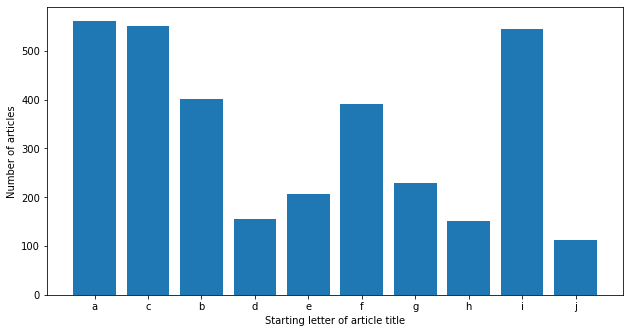

In [35]:
def makeChart5():
    d = {}
    for title in df['title']:
        fl = title[0].lower()
        if fl in d:
            d[fl] += 1
        else:
            d[fl] = 1
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(list(d),list(d.values()))
    ax.set_xlabel('Starting letter of article title')
    ax.set_ylabel('Number of articles')
makeChart5()

#### Challenges

Certainly, one of the biggest challenges of Task 5 was understanding the structure of a HTML-documents. Here, The Browser Developer Tools (called Devtools in Chrome) came in handy for locating the appropriate objects.

#### Code for newsSpider

<a id='newsSpider'></a>

    import scrapy
    import csv

    class newsSpider(scrapy.Spider):
        name = "test"
        id = 0

        start_urls = ["https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&from=A"]


        def parse(self, response):
            pastJ = False
            next_page = response.xpath('//div[@id="mw-pages"]/a/@href').getall()[1]
            groups = response.xpath('//div[@id="mw-pages"]//div[@class="mw-category-group"]')

            # iter groups based on first letter
            for group in groups:
                if group.xpath('h3/text()').get().lower() <= 'j':
                    for page in group.xpath('ul/li/a/@href').getall():
                        page = response.urljoin(page)
                        yield scrapy.Request(page, callback=self.parse1)
                else:
                    pastJ = True

            # if not past J: go to next page
            if not pastJ:
                next_page = response.urljoin(next_page)
                yield scrapy.Request(next_page, callback=self.parse)


        def parse1(self, response):
            """function to scrape title, url, date_written, keywords and content form from a wikinews article
            and write it to the file 'scrape.wikinews.csv' """

            title = response.xpath('//h1[@id="firstHeading"]/text()').get()
            url = response.url
            date_written = response.xpath('//span[@id="publishDate"]/@title').get()
            keywords = response.xpath('//div[@id="mw-normal-catlinks"]/ul/li/a/text()').getall()
            body = ''.join(response.xpath('//div[@id="mw-content-text"]//text()').getall())

            with open('scrape_wikinews.csv','a') as f:
                writer = csv.writer(f)
                writer.writerow(list(map(str,[self.id,title,url,date_written,keywords,title+'\n'+body])))
                self.id += 1
